In [1]:
!pwd

/Users/herb/Github/GW_parameter_estimation/notebooks


In [15]:
try:
    from gwtoolkit.gw import WaveformDataset
    from model import flows
    from model.transformer import TransformerEncoder    
    from model.utils import MultipleOptimizer, MultipleScheduler
except:
    import sys
    sys.path.insert(0, '../GWToolkit/')
    sys.path.insert(0, '..')
    from gwtoolkit.gw import WaveformDataset
    from model import flows
    from model.transformer import TransformerEncoder
    from model.utils import MultipleOptimizer, MultipleScheduler
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from nflows.utils import get_num_parameters

In [16]:
sampling_frequency = 4096
duration = 8
conversion = 'BBH'
waveform_approximant = 'IMRPhenomPv2'
# waveform_approximant = 'SEOBNRv4P' ## TODO
# waveform_approximant = 'IMRPhenomPv2_NRTidal'
# waveform_approximant = 'IMRPhenomXP'
reference_frequency = 50.
minimum_frequency = 20.
base = 'bilby'
dets = ['H1', 'L1']
###

wfd = WaveformDataset(sampling_frequency=sampling_frequency, duration=duration, conversion=conversion)
waveform_arguments = dict(waveform_approximant=waveform_approximant,
                          reference_frequency=reference_frequency, 
                          minimum_frequency=minimum_frequency)
wfd.load_prior_source_detector(#filename='../gwtoolkit/gw/prior_files/default.prior',
    base=base,
    dets=dets,
    waveform_arguments=waveform_arguments)

No prior given, using default BBH priors.


In [17]:
from collections import namedtuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas
import numpy

In [18]:
class WaveformDatasetTorch(Dataset):
    """Waveform dataset"""

    def __init__(self, wfd, num, start_time, geocent_time, 
                 target_optimal_snr_tuple=None, 
                 target_labels = None,
                 stimulated_whiten_ornot = False,
                 transform_data=None,
                 transform_params=None,
                 rand_transform_data=None):
        """
        Args:

        """
        assert isinstance(num, int)
        assert isinstance(start_time, float)
        assert isinstance(geocent_time, tuple)
        assert (isinstance(target_optimal_snr_tuple, tuple) if None else True)
        Record = namedtuple('Record', 'num start_time geocent_time \
                             target_labels \
                             target_optimal_snr_tuple \
                             stimulated_whiten_ornot')
        self.var = Record(num, start_time, geocent_time, 
                          self._set_target_labels(target_labels),
                          target_optimal_snr_tuple, 
                          stimulated_whiten_ornot)
        self.wfd = wfd
        self.transform_data = transform_data
        self.transform_params = transform_params
        self.rand_transform_data = rand_transform_data

        self.time_array = None
        self.data_block = None
        self.params_block = None
        self._update()

    def __len__(self):
        return self.var.num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx == 0: # Update self.data_block and self.params_block
            self._update()

        if self.rand_transform_data:
            self.data_block[idx] = self.rand_transform_data(self.data_block[idx])

        return (self.data_block[idx], self.params_block[idx])

    def _update(self):
        # data = 
        # (signal_block,  # Pure signals, (num, len(wfd.dets), ...)
        #  signal_meta,  # parameters of the signals, dict
        #  noise_block,  # Pure colored detector noises, (num, len(wfd.dets), ...)
        #  data_whitened, # mixed signal+noise data whitened by stimulated dets' PSD
        # )
        data = self.wfd.time_waveform_response_block(
            self.var.num,
            self.var.start_time,
            self.var.geocent_time,
            self.var.target_optimal_snr_tuple,
        )
        if self.var.stimulated_whiten_ornot:
            self.data_block = data[3]
        else:
            self.data_block = data[0] + data[2]
        
        # Consider the target params labels
        self.params_block = pandas.DataFrame({key: data[1][key] 
                                              for key in data[1].keys() 
                                              if key in self.var.target_labels}).values

        if self.transform_data:
            self.data_block = self.transform_data(self.data_block)
        if self.transform_params:
            self.params_block = self.transform_params(self.params_block)       

    def _set_target_labels(self, labels=None):
        # default 15 labels
        _labels = ['mass_ratio', 'chirp_mass', 
                   'luminosity_distance', 
                   'dec', 'ra', 'theta_jn', 'psi', 'phase', 
                   'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 
                   'geocent_time']
        return list(set(_labels) & set(labels)) if labels is not None else _labels

#         self.data_block = signal_block + noise_block
#         self.time_array = self.wfd.time_array

In [19]:
class Normalize_params(object):
    """Standardize for parameters
    """

    def __init__(self, kind, **kwargs):
        if kind == 'minmax':
            self.standardize = self.minmaxscaler
            self.standardize_inv = self.minmaxscaler_inverse
            assert 'wfd' in kwargs
            assert 'labels' in kwargs
            self.kwargs = kwargs
            print(f"Standardize by '{kind}' for {len(kwargs['labels'])} parameters.")

    def __call__(self, sample):
        # Self check
        #assert numpy.allclose(samples, self.minmaxscaler_inverse(self.minmaxscaler(sample, wfd, labels), wfd, labels))
        sample = self.standardize(sample, **self.kwargs)
        return sample

    def minmaxscaler(self, X, wfd, labels, feature_range=(0, 1)):
        scale = preprocessing.MinMaxScaler(feature_range=feature_range)
        minimaximum = numpy.asarray([[wfd.prior[label].minimum, wfd.prior[label].maximum] for label in labels])
        scale.fit(minimaximum.T)
        return scale.transform(X)

    def minmaxscaler_inverse(self, X, wfd, labels, feature_range=(0, 1)):
        scale = preprocessing.MinMaxScaler(feature_range=feature_range)
        minimaximum = numpy.asarray([[wfd.prior[label].minimum, self.wfd.prior[label].maximum] for label in labels])
        scale.fit(minimaximum.T)
        return scale.inverse_transform(X)
    
class Patching_data(object):
    """Patching for strain
    """

    def __init__(self, patch_size, overlap, sampling_frequency):
        """
        patch_size, sec
        overlap, sec
        """
        self.nperseg = int(patch_size * sampling_frequency) # sec
        # noverlap must be less than nperseg.
        self.noverlap = int(overlap * self.nperseg)  # [%]
        # nstep = nperseg - noverlap
        print(f'Patching with patch size={patch_size}s and overlap={overlap}s.')

    def __call__(self, x):
        shape = x.shape
        # Created strided array of data segments
        if self.nperseg == 1 and self.noverlap == 0:
            return x[..., numpy.newaxis]
        else:
            # https://stackoverflow.com/a/5568169  also
            # https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/#_fft_helper
            nstep = self.nperseg - self.noverlap
            shape = shape[:-1]+((shape[-1]-self.noverlap)//nstep, self.nperseg)
            strides = x.strides[:-1]+(nstep*x.strides[-1], x.strides[-1])
            return numpy.lib.stride_tricks.as_strided(x, shape=shape,
                                                      strides=strides).reshape(shape[0], -1, self.noverlap)
        
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)

In [20]:
target_labels = ['mass_ratio', 'chirp_mass', 
                 'luminosity_distance', 
                 'dec', 'ra', 'theta_jn', 'psi', 'phase', 
                 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 
                 'geocent_time']
patch_size = 0.5
overlap = 0.5
composed_data = transforms.Compose([Patching_data(patch_size=patch_size, overlap=overlap, sampling_frequency=sampling_frequency)])
composed_params = transforms.Compose([Normalize_params('minmax', wfd=wfd, labels=target_labels), ToTensor()])
rand_transform_data = transforms.Compose([ToTensor()])

Patching with patch size=0.5s and overlap=0.5s.
Standardize by 'minmax' for 15 parameters.


In [21]:
# pytorch wrappers
wfdt = WaveformDatasetTorch(wfd, num=50,  
                            start_time=1126259462.4-6, 
                            geocent_time=(1126259462.4-0.1, 1126259462.4+0.1), 
                            target_optimal_snr_tuple=(0, 30),
                            target_labels=target_labels,
                            stimulated_whiten_ornot=True,
                            transform_data=composed_data,
                            transform_params=composed_params,
                            #rand_transform_data=rand_transform_data,
                           )
wfdt[:][0].std()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.38it/s]


45.76304384693581

In [22]:
wfdt[:4][0].shape, wfdt[:4][1].shape

((4, 124, 1024), torch.Size([4, 15]))

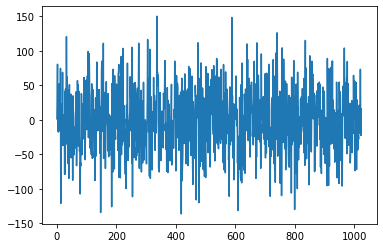

In [23]:
plt.plot(wfdt[:2][0][0,0])
# wfdt[:][1].max(axis=0), wfdt[:][1].min(axis=0)

In [24]:
batch_size = 8
# DataLoader objects
train_loader = DataLoader(
    wfdt, batch_size=batch_size, shuffle=True, pin_memory=True,
#     num_workers=8,
    worker_init_fn=lambda _: numpy.random.seed(
        int(torch.initial_seed()) % (2**32-1)))
# test_loader = DataLoader(
#     wfd_test, batch_size=batch_size, shuffle=False, pin_memory=True,
#     num_workers=16,
#     worker_init_fn=lambda _: numpy.random.seed(
#         int(torch.initial_seed()) % (2**32-1)))

In [25]:
for x, y in train_loader:
    break
x.shape, y.shape

(torch.Size([8, 124, 1024]), torch.Size([8, 15]))

In [26]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')


In [45]:
## Embedding network
ffn_num_hiddens_transformer = 128
num_heads_transformer = 1
num_layers_transformer = 3
dropout_transformer = 0.1
# Define input of Transformer
norm_shape = [wfdt.data_block.shape[-2], wfdt.data_block.shape[-1]]

Transformer = TransformerEncoder(
    noEmbedding=True,
    vocab_size=200, # for embeding only
    key_size=norm_shape[1],
    query_size=norm_shape[1],
    value_size=norm_shape[1],
    num_hiddens=norm_shape[1],
    norm_shape=norm_shape,
    ffn_num_input=norm_shape[1],
    ffn_num_hiddens=ffn_num_hiddens_transformer,
    num_heads=num_heads_transformer,
    num_layers=num_layers_transformer,
    dropout=dropout_transformer,
    valid_lens=None,
)

embedding_net = nn.Sequential(Transformer)
embedding_net.to(device)
embedding_net.train();

In [46]:
print(get_num_parameters(embedding_net))

15101312


In [47]:
context = embedding_net(x.to(torch.float32).to(device, non_blocking=True))
x.shape, context.shape

(torch.Size([8, 124, 1024]), torch.Size([8, 124, 1024]))

In [48]:
Transformer.blks[num_layers_transformer-1].ffn

PositionWiseFFN(
  (dense1): Linear(in_features=1024, out_features=128, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=128, out_features=1024, bias=True)
)

In [49]:
## Flow network
nflows=15
hidden_dims=512
num_transform_blocks=10
activation='elu'
dropout_probability=0.0
batch_norm=True
nbins=8
tail_bound=1.0
apply_unconditional_transform=False
base_transform_type='rq-coupling'
# Define input of NDE flow
input_dim = 15
context_dim = 400#data.shape[-1]


## Transformer Flow
nflows=2
hidden_features=8
num_transform_blocks=2
base_transform_type='rq-coupling+transformer'


base_transform_kwargs={
    'hidden_dim': hidden_dims,
    'num_transform_blocks': num_transform_blocks, # also for transformer
    'activation': activation,
    'dropout_probability': dropout_probability,
    'batch_norm': batch_norm,
    'num_bins': nbins,
    'tail_bound': tail_bound,
    'apply_unconditional_transform': apply_unconditional_transform,
    'base_transform_type': base_transform_type,

    # Only for transformer
      'hidden_features':32,
      'context_tokens':124,
      'context_features':1024,
      'ffn_num_hiddens_transofmer':32,
      'num_heads_transformer':2,
      'num_transformer_layers':2,
      'dropout_transformer':0.1,
}

flow_creator = flows.create_NDE_model
flow_net = flow_creator(input_dim=input_dim,
                        context_dim=context_dim,
                        num_flow_steps=nflows,
                        base_transform_kwargs=base_transform_kwargs)
flow_net.to(device);
flow_net.train();

In [50]:
print(get_num_parameters(flow_net))

45974489


In [51]:
lr=0.0001
lr_transformer=0.0001
lr_anneal_method='cosine'
lr_annealing=True
steplr_gamma=0.5,
steplr_step_size=80,

total_epochs=20
epoch=1


if embedding_net is not None:
    print('Opt for Transformer!!')
    op1 = torch.optim.Adam(flow_net.parameters(), lr=lr)
    op2 = torch.optim.Adam(embedding_net.parameters(), lr=lr_transformer)
    optimizer = MultipleOptimizer(op1, op2)
else:
    optimizer = torch.optim.Adam(flow_net.parameters(), lr=lr)
if lr_annealing is True:            
    if lr_anneal_method == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=steplr_step_size,
            gamma=steplr_gamma)
    elif embedding_net is not None:
        print('lr_sch (cosine) for Transformer!!')
        lr_sch1 = torch.optim.lr_scheduler.CosineAnnealingLR(op1, T_max=total_epochs)
        lr_sch2 = torch.optim.lr_scheduler.CosineAnnealingLR(op2, T_max=total_epochs)                
        scheduler = MultipleScheduler(lr_sch1, lr_sch2)                    
    elif lr_anneal_method == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=total_epochs,
        )
    elif lr_anneal_method == 'cosineWR':
        scheduler = (
            torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=10,
                T_mult=2
            )
        )

Opt for Transformer!!
lr_sch (cosine) for Transformer!!


In [52]:
print(get_num_parameters(embedding_net))
print(get_num_parameters(flow_net))

15101312
45974489


In [53]:
def train(flow_net, train_loader, optimizer, epoch,
                device=None, embedding_net=None,
                output_freq=50, annealing=False):
    train_loss = 0.0

    start_time = time.time()
    for batch_idx, (h, x) in enumerate(train_loader):

        optimizer.zero_grad()

        if device is not None:
            h = h.to(torch.float32).to(device, non_blocking=True)
            x = x.to(torch.float32).to(device, non_blocking=True)

        y = h

        # Compute log prob
        if embedding_net is not None:
            context = embedding_net(y)
            loss = - flow_net.log_prob(x, context=context)
        else:
            loss = - flow_net.log_prob(x, context=y)

        # Keep track of total loss.
        train_loss += loss.sum()

        loss = loss.mean()

        loss.backward()
        optimizer.step()

        if (output_freq is not None) and (batch_idx % output_freq == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tCost: {:.2f}s'.format(
                epoch, batch_idx *
                train_loader.batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item(), time.time()-start_time))
            start_time = time.time()

    train_loss = train_loss.item() / len(train_loader.dataset)
    # train_loss = train_loss.item() / total_weight.item()
    print('Train Epoch: {} \tAverage Loss: {:.4f}'.format(
        epoch, train_loss))

In [54]:
# pm.train(args.epochs,
#          output_freq=args.output_freq,
#          transformer=pm.transformer,
#          kl_annealing=args.kl_annealing,
#          snr_annealing=args.snr_annealing)

output_freq = 5
epoch_minimum_test_loss = 1
snr_annealing=False

for epoch in range(epoch, epoch + total_epochs):

    if embedding_net is not None:
        for Dict in optimizer.state_dict():
            print('Learning rate: {}'.format(
                Dict['param_groups'][0]['lr']))
    else:
        print('Learning rate: {}'.format(
            optimizer.state_dict()['param_groups'][0]['lr']))
    train_loss = train(
        flow_net,
        train_loader,
        optimizer,
        epoch,
        device,
        embedding_net,
        output_freq,
        snr_annealing)
#     test_loss = flows.test_epoch(
#         model,
#         iterator,
#         epoch,
#         device,
#         transformer,
#         snr_annealing)


Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 1 [0/50 (0%)]	Loss: 16.5858	Cost: 6.09s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.07it/s]


Train Epoch: 1 [40/50 (71%)]	Loss: 14.0558	Cost: 20.44s
Train Epoch: 1 	Average Loss: 14.7491
Learning rate: 0.0001
Learning rate: 0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.03it/s]


Train Epoch: 2 [0/50 (0%)]	Loss: 11.8649	Cost: 7.48s
Train Epoch: 2 [40/50 (71%)]	Loss: 12.5631	Cost: 17.17s
Train Epoch: 2 	Average Loss: 12.6198
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 3 [0/50 (0%)]	Loss: 11.6198	Cost: 3.43s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.81it/s]


Train Epoch: 3 [40/50 (71%)]	Loss: 9.4004	Cost: 20.89s
Train Epoch: 3 	Average Loss: 10.7459
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 4 [0/50 (0%)]	Loss: 8.8578	Cost: 3.44s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.38it/s]


Train Epoch: 4 [40/50 (71%)]	Loss: 12.1012	Cost: 19.78s
Train Epoch: 4 	Average Loss: 9.6135
Learning rate: 0.0001
Learning rate: 0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.85it/s]


Train Epoch: 5 [0/50 (0%)]	Loss: 12.3877	Cost: 6.11s
Train Epoch: 5 [40/50 (71%)]	Loss: 11.4117	Cost: 17.17s
Train Epoch: 5 	Average Loss: 11.8720
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 6 [0/50 (0%)]	Loss: 9.8822	Cost: 5.03s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.74it/s]


Train Epoch: 6 [40/50 (71%)]	Loss: 10.2891	Cost: 20.43s
Train Epoch: 6 	Average Loss: 10.5786
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 7 [0/50 (0%)]	Loss: 9.3080	Cost: 3.43s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.78it/s]


Train Epoch: 7 [40/50 (71%)]	Loss: 10.6952	Cost: 20.93s
Train Epoch: 7 	Average Loss: 9.2914
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 8 [0/50 (0%)]	Loss: 10.8660	Cost: 3.43s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.15it/s]


Train Epoch: 8 [40/50 (71%)]	Loss: 12.2400	Cost: 19.82s
Train Epoch: 8 	Average Loss: 11.1224
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 9 [0/50 (0%)]	Loss: 11.5930	Cost: 3.43s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.95it/s]


Train Epoch: 9 [40/50 (71%)]	Loss: 10.9482	Cost: 19.83s
Train Epoch: 9 	Average Loss: 10.5412
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 10 [0/50 (0%)]	Loss: 8.6597	Cost: 3.46s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.23it/s]


Train Epoch: 10 [40/50 (71%)]	Loss: 9.2928	Cost: 19.80s
Train Epoch: 10 	Average Loss: 9.0284
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 11 [0/50 (0%)]	Loss: 8.9867	Cost: 3.43s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.11it/s]


Train Epoch: 11 [40/50 (71%)]	Loss: 9.6662	Cost: 24.51s
Train Epoch: 11 	Average Loss: 9.3760
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 12 [0/50 (0%)]	Loss: 8.8032	Cost: 3.60s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.94it/s]


Train Epoch: 12 [40/50 (71%)]	Loss: 8.5587	Cost: 20.24s
Train Epoch: 12 	Average Loss: 8.9587
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 13 [0/50 (0%)]	Loss: 8.2636	Cost: 3.47s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.38it/s]


Train Epoch: 13 [40/50 (71%)]	Loss: 8.5540	Cost: 21.31s
Train Epoch: 13 	Average Loss: 8.7919
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 14 [0/50 (0%)]	Loss: 7.8680	Cost: 3.49s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.07it/s]


Train Epoch: 14 [40/50 (71%)]	Loss: 9.8200	Cost: 21.74s
Train Epoch: 14 	Average Loss: 9.7506
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 15 [0/50 (0%)]	Loss: 8.8102	Cost: 3.48s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.43it/s]


Train Epoch: 15 [40/50 (71%)]	Loss: 10.0944	Cost: 20.28s
Train Epoch: 15 	Average Loss: 8.3675
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 16 [0/50 (0%)]	Loss: 8.7857	Cost: 5.08s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.83it/s]


Train Epoch: 16 [40/50 (71%)]	Loss: 10.8487	Cost: 20.95s
Train Epoch: 16 	Average Loss: 9.9435
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 17 [0/50 (0%)]	Loss: 10.7548	Cost: 3.50s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.61it/s]


Train Epoch: 17 [40/50 (71%)]	Loss: 11.5711	Cost: 22.62s
Train Epoch: 17 	Average Loss: 10.1575
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 18 [0/50 (0%)]	Loss: 7.9576	Cost: 4.21s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.34it/s]


Train Epoch: 18 [40/50 (71%)]	Loss: 10.4427	Cost: 20.61s
Train Epoch: 18 	Average Loss: 9.9138
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 19 [0/50 (0%)]	Loss: 9.5986	Cost: 3.60s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.71it/s]


Train Epoch: 19 [40/50 (71%)]	Loss: 9.4770	Cost: 21.73s
Train Epoch: 19 	Average Loss: 10.3794
Learning rate: 0.0001
Learning rate: 0.0001
Train Epoch: 20 [0/50 (0%)]	Loss: 11.3594	Cost: 3.52s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.32it/s]


Train Epoch: 20 [40/50 (71%)]	Loss: 11.8026	Cost: 25.25s
Train Epoch: 20 	Average Loss: 11.4140


---

In [5]:
num = 50
trigge_rtime = 1126259462.4
start_time = trigge_rtime - 6
geocent_time = (trigge_rtime-0.1, trigge_rtime+0.1)
target_optimal_snr_tuple = (0, 30)
##

# signal_block, signal_meta, noise_block = wfd.frequency_waveform_response_block(
#     num,
#     start_time,
#     geocent_time,
#     target_optimal_snr_tuple,
# )
# freq_array = wfd.frequency_array
# data_block = signal_block + noise_block
# signal_block.shape, noise_block.shape, signal_meta.keys()


signal_block, signal_meta, noise_block, data_whitened = wfd.time_waveform_response_block(
    num,
    start_time,
    geocent_time,
    target_optimal_snr_tuple,
)
time_array = wfd.time_array
data_block = signal_block + noise_block
signal_block.shape, noise_block.shape, signal_meta.keys()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.21it/s]


((50, 2, 32768),
 (50, 2, 32768),
 dict_keys(['mass_ratio', 'chirp_mass', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'geocent_time', 'matched_filter_snr', 'optimal_snr']))

array([30.        , 14.64148912])

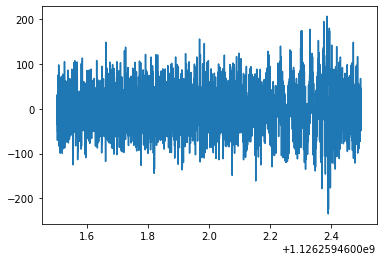

In [4]:
mask = (time_array > 1126259461.5) & (time_array < 1126259462.5)
plt.plot(time_array[mask], data_whitened[0,0][mask])
signal_meta['optimal_snr'][0]

In [5]:
labels = ['mass_ratio', 'chirp_mass', 
          'luminosity_distance', 
          'dec', 'ra', 'theta_jn', 'psi', 'phase', 
          'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 
          'geocent_time',]
df = pd.DataFrame({key: signal_meta[key] for key in signal_meta.keys() if key in labels})

In [6]:
def minmaxscaler(X, feature_range=(0, 1), minimaximum=None):
    """Transform features by scaling each feature to a given range.

    This estimator scales and translates each feature individually such
    that it is in the given range on the training set, e.g. between
    zero and one.

    The standard transformation is given by::

        X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        X_scaled = X_std * (max - min) + min

    where min, max = feature_range. Or you can scale each feature with
    target range bouondary by seting `minimaximum` as an array with shape
    of (num_of_features, 2).

    This transformation is often used as an alternative to zero mean,
    unit variance scaling.    
    """
    if minimaximum is not None:
        minimum = minimaximum[:,0]
        maximum = minimaximum[:,1]
    else:
        minimum = X.min(axis=0)
        maximum = X.max(axis=0)
    X_std = (X - minimum) / (maximum - minimum)
    return X_std * (feature_range[1] - feature_range[0]) + feature_range[0]

In [7]:
def minmaxscaler(X, wfd, feature_range=(0, 1)):
    scale = preprocessing.MinMaxScaler(feature_range=feature_range)
    minimaximum = np.asarray([[wfd.prior[label].minimum, wfd.prior[label].maximum] for label in labels])
    scale.fit(minimaximum.T)
    return scale.transform(X)

def minmaxscaler_inverse(X, wfd, feature_range=(0, 1)):
    scale = preprocessing.MinMaxScaler(feature_range=feature_range)
    minimaximum = np.asarray([[wfd.prior[label].minimum, wfd.prior[label].maximum] for label in labels])
    scale.fit(minimaximum.T)
    return scale.inverse_transform(X)

assert np.allclose(df.values, minmaxscaler_inverse(minmaxscaler(df.values, wfd), wfd))
targets = minmaxscaler(df.values, wfd)

array([30.        , 14.64148912])

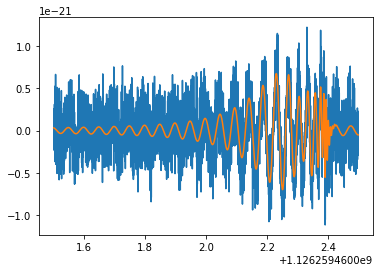

In [8]:
mask = (time_array > 1126259461.5) & (time_array < 1126259462.5)
plt.plot(time_array[mask], data_block[0,0][mask])
plt.plot(time_array[mask], signal_block[0,0][mask])
# plt.plot(time_array[mask], data[mask])
# plt.plot(time_array[mask], signal[mask])
signal_meta['optimal_snr'][0]

In [9]:
# Way 1: with whitening
data_whitened.shape

(50, 2, 32768)

In [10]:
# Way 2: without whitening
(data_block + noise_block).shape

(50, 2, 32768)

In [11]:
patch_size = 1 # sec
overlap = 0.5 # [%]

nperseg = patch_size * sampling_frequency # sec
# noverlap must be less than nperseg.
noverlap = int(overlap*nperseg)  # [%]
# nstep = nperseg - noverlap

def _strided_array(x, nperseg, noverlap):
    # Created strided array of data segments
    if nperseg == 1 and noverlap == 0:
        return x[..., np.newaxis]
    else:
        # https://stackoverflow.com/a/5568169  also
        # https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/#_fft_helper
        step = nperseg - noverlap
        shape = x.shape[:-1]+((x.shape[-1]-noverlap)//step, nperseg)
        strides = x.strides[:-1]+(step*x.strides[-1], x.strides[-1])
        return np.lib.stride_tricks.as_strided(x, shape=shape,
                                               strides=strides)

In [12]:
data = _strided_array(data_whitened, nperseg, noverlap)
data = data.reshape(num, -1, noverlap)
data.shape

(50, 60, 2048)

In [13]:
targets.shape

(50, 15)

In [14]:
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
trigge_rtime = 1126259462.4
start_time = trigge_rtime - 6
geocent_time = (trigge_rtime-0.1, trigge_rtime+0.1)
target_optimal_snr_tuple = (0, 30)

In [15]:
batch_size = 5

dataset = TensorDataset(torch.tensor(data), torch.tensor(targets))
iterator = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [16]:
for d, l in iterator:
    break
d.shape, l.shape, d.dtype, l.dtype

(torch.Size([5, 60, 2048]), torch.Size([5, 15]), torch.float64, torch.float64)

In [17]:
nflows=15
hidden_dims=512
num_transform_blocks=10
activation='elu'
dropout_probability=0.0
batch_norm=True
nbins=8
tail_bound=1.0
apply_unconditional_transform=False
base_transform_type='rq-coupling'

use_cuda = True
if use_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')

base_transform_kwargs={
    'hidden_dim': hidden_dims,
    'num_transform_blocks': num_transform_blocks,
    'activation': activation,
    'dropout_probability': dropout_probability,
    'batch_norm': batch_norm,
    'num_bins': nbins,
    'tail_bound': tail_bound,
    'apply_unconditional_transform': apply_unconditional_transform,
    'base_transform_type': base_transform_type
}

model_creator = flows.create_NDE_model
input_dim = targets.shape[-1]
context_dim = 400#data.shape[-1]

model = model_creator(input_dim=input_dim,
                      context_dim=context_dim,
                      num_flow_steps=nflows,
                      base_transform_kwargs=base_transform_kwargs)
model.to(device);

In [18]:
ffn_num_hiddens_transformer = 128
num_heads_transformer = 1
num_layers_transformer = 6
dropout_transformer = 0.1

norm_shape = [data.shape[-2], data.shape[-1]]
transformer = {
    'encoder': TransformerEncoder(
        vocab_size=200, # for embeding only
        key_size=norm_shape[1],
        query_size=norm_shape[1],
        value_size=norm_shape[1],
        num_hiddens=norm_shape[1],
        norm_shape=norm_shape,
        ffn_num_input=norm_shape[1],
        ffn_num_hiddens=ffn_num_hiddens_transformer,
        num_heads=num_heads_transformer,
        num_layers=num_layers_transformer,
        dropout=dropout_transformer,
        noEmbedding=True,
        )
    }
transformer['encoder'].to(device)
transformer['encoder'].train()
transformer['valid_lens'] = None#torch.tensor([norm_shape[1],]*batch_size).to(device, non_blocking=True)
# transformer['valid_lens'] = transformer['valid_lens'].reshape(-1, 4*transformer['valid_lens'][1])
norm_shape, #transformer['valid_lens'].shape

([60, 2048],)

In [19]:
lr=0.0001
lr_transformer=0.5
lr_anneal_method='cosine'
lr_annealing=True
steplr_gamma=0.5,
steplr_step_size=80,

total_epochs=10000
epoch=1


if transformer:
    print('Opt for Transformer!!')
    transformer = transformer
    op1 = torch.optim.Adam(model.parameters(), lr=lr)
    op2 = torch.optim.Adam(transformer['encoder'].parameters(), 
                           lr=lr_transformer)
    optimizer = MultipleOptimizer(op1, op2)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
if lr_annealing is True:            
    if lr_anneal_method == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=steplr_step_size,
            gamma=steplr_gamma)
    elif transformer:
        print('lr_sch (cosine) for Transformer!!')
        lr_sch1 = torch.optim.lr_scheduler.CosineAnnealingLR(op1, T_max=total_epochs)
        lr_sch2 = torch.optim.lr_scheduler.CosineAnnealingLR(op2, T_max=total_epochs)                
        scheduler = MultipleScheduler(lr_sch1, lr_sch2)                    
    elif lr_anneal_method == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=total_epochs,
        )
    elif lr_anneal_method == 'cosineWR':
        scheduler = (
            torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=10,
                T_mult=2
            )
        )

Opt for Transformer!!
lr_sch (cosine) for Transformer!!


In [20]:
# pm.train(args.epochs,
#          output_freq=args.output_freq,
#          transformer=pm.transformer,
#          kl_annealing=args.kl_annealing,
#          snr_annealing=args.snr_annealing)

output_freq = 50
epoch_minimum_test_loss = 1
snr_annealing=False

for epoch in range(epoch, epoch + total_epochs):
    
    if transformer:
        for Dict in optimizer.state_dict():
            print('Learning rate: {}'.format(
                Dict['param_groups'][0]['lr']))
    else:
        print('Learning rate: {}'.format(
            optimizer.state_dict()['param_groups'][0]['lr']))
    train_loss = flows.train_epoch(
        model,
        iterator,
        optimizer,
        epoch,
        device,
        transformer,
        output_freq,
        snr_annealing)
    test_loss = flows.test_epoch(
        model,
        iterator,
        epoch,
        device,
        transformer,
        snr_annealing)


Learning rate: 0.0001
Learning rate: 0.5
Train Epoch: 1 [0/50 (0%)]	Loss: 25.6303	Cost: 6.65s


KeyboardInterrupt: 

## Sample of Nestedspace

```python
Nestedspace(
    activation='elu', 
    apply_unconditional_transform=False, 
    base_transform_type='rq-coupling', 
    basis_dir='data/GW170104_sample_prior_basis/', 
    batch_norm=True, 
    batch_size=2048,
    bw_dstar=None,
    cuda=True,
    data_dir='data/GW170104_sample_prior_basis/',
    detectors=None,
    distance_prior=None,
    distance_prior_fn='uniform_distance',
    dont_sample_extrinsic_only=False,
    dropout_probability=0.0,
    epochs=10000,
    flow_lr=None, 
    hidden_dims=512,
    kl_annealing=True,
    lr=0.0001,
    lr_anneal_method='cosine',
    lr_annealing=True,
    mixed_alpha=0.0,
    mode='train', 
    model_dir='models/GW170104_sample_uniform_100basis_all_posterior_prior/',
    model_source='new',
    model_type='nde',
    nbins=8,
    nflows=15,
    nsample=100000,
    nsamples_target_event=50000,
    num_transform_blocks=10,
    output_freq=10,
    sampling_from='posterior',
    save=True,
    save_aux_filename='waveforms_supplementary.hdf5',
    save_model_name='model.pt',
    snr_annealing=False,
    snr_threshold=None,
    steplr_gamma=0.5,
    steplr_step_size=80,
    tail_bound=1.0,
    transfer_epochs=0,
    truncate_basis=100)
```

## data precessing (in class)

In [7]:
import sys, os
sys.path.append('..')

In [8]:
from inference.gwpe_main import PosteriorModel

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
model_dir='models/GW150914_sample_uniform_100basis_all_uniform_prior/'
data_dir='data/GW150914_sample_prior_basis/'
basis_dir='data/GW150914_sample_prior_basis/'
dont_sample_extrinsic_only=False
save_model_name='model.pt'
save_aux_filename='waveforms_supplementary.hdf5'
cuda=True

batch_size=2048//64
detectors=None
truncate_basis=100
snr_annealing=False
snr_threshold=None
distance_prior_fn='uniform_distance'
sampling_from='uniform'
nsamples_target_event=500#00
mixed_alpha=0.0
nsample=32*10#000
distance_prior=None
bw_dstar=None
####
pm = PosteriorModel(model_dir=model_dir,
                    data_dir=data_dir,
                    basis_dir=basis_dir,
                    sample_extrinsic_only=dont_sample_extrinsic_only,
                    save_model_name=save_model_name,
                    save_aux_filename=save_aux_filename,
                    use_cuda=cuda)
print('Device', pm.device)
print('Loading dataset')

####
pm.load_dataset(batch_size=batch_size,
                detectors=detectors,
                truncate_basis=truncate_basis,
                snr_threshold=snr_threshold,
                distance_prior_fn=distance_prior_fn,
                sampling_from=sampling_from,
                nsamples_target_event=nsamples_target_event,
                mixed_alpha=mixed_alpha,
                nsample=nsample,
                distance_prior=distance_prior,
                bw_dstar=bw_dstar)
print('Detectors:', pm.detectors)

Device cpu
Loading dataset
Sampling 320 sets of parametersfrom uniform prior.
init training...
init relative whitening...


  0%|          | 0/1001 [00:00<?, ?it/s]

Truncating reduced basis from 600 to 100 elements.
initialidze reduced basis aux...
Building time translation matrices.


  0%|          | 0/288 [00:00<?, ?it/s]

calculate threshold standardizatison...
  Generating 288 detector waveforms
Setting extrinsic parameters to fiducial values.


  0%|          | 0/10 [00:00<?, ?it/s]

  Calculating new standardization factors.
Loading load_all_bilby_samples...


  0%|          | 0/10 [00:00<?, ?it/s]

Loading load_all_event_strain...
init relative whitening...



  1%|▏         | 13/1001 [00:00<00:07, 124.62it/s]

Building time translation matrices.



 10%|█         | 1/10 [00:08<01:17,  8.58s/it]

init relative whitening...



  1%|▏         | 14/1001 [00:00<00:07, 133.01it/s]

Building time translation matrices.



 20%|██        | 2/10 [00:16<01:06,  8.28s/it]

init relative whitening...



  1%|          | 12/1001 [00:00<00:08, 117.94it/s]

Building time translation matrices.



 30%|███       | 3/10 [00:24<00:57,  8.17s/it]

init relative whitening...



  1%|▏         | 14/1001 [00:00<00:07, 137.14it/s]

Building time translation matrices.



 40%|████      | 4/10 [00:34<00:51,  8.65s/it]

init relative whitening...



  1%|          | 11/1001 [00:00<00:09, 108.35it/s]

Building time translation matrices.



 50%|█████     | 5/10 [00:43<00:44,  8.85s/it]

init relative whitening...



  1%|          | 11/1001 [00:00<00:09, 106.17it/s]

Building time translation matrices.



 60%|██████    | 6/10 [00:52<00:35,  8.82s/it]

init relative whitening...



  1%|          | 11/1001 [00:00<00:09, 103.28it/s]

Building time translation matrices.



 70%|███████   | 7/10 [01:01<00:26,  8.92s/it]

init relative whitening...



  1%|          | 11/1001 [00:00<00:09, 107.38it/s]

Building time translation matrices.



 80%|████████  | 8/10 [01:10<00:17,  8.92s/it]

init relative whitening...



  1%|          | 11/1001 [00:00<00:09, 108.78it/s]

Building time translation matrices.



 90%|█████████ | 9/10 [01:19<00:08,  8.99s/it]

init relative whitening...



  1%|          | 11/1001 [00:00<00:09, 103.46it/s]

Building time translation matrices.



100%|██████████| 10/10 [01:28<00:00,  8.86s/it]

Detectors: ['H1', 'L1']


In [3]:
nflows=15
hidden_dims=512
num_transform_blocks=10
activation='elu'
dropout_probability=0.0
batch_norm=True
nbins=8
tail_bound=1.0
apply_unconditional_transform=False
base_transform_type='rq-coupling'

pm.construct_model(
    'nde',
    num_flow_steps=nflows,
    base_transform_kwargs={
        'hidden_dim': hidden_dims,
        'num_transform_blocks': num_transform_blocks,
        'activation': activation,
        'dropout_probability': dropout_probability,
        'batch_norm': batch_norm,
        'num_bins': nbins,
        'tail_bound': tail_bound,
        'apply_unconditional_transform': apply_unconditional_transform,
        'base_transform_type': base_transform_type
    }
)

In [4]:
# pm.model_type, pm.model

In [70]:
# import torch
# # # import inference
# # # import math
# # # from torch import nn
# # # pos_encoding = inference.transformer.PositionalEncoding(100, 0.5)

# # import inference
# # # import imp
# # # imp.reload(inference)
# from inference.transformer import TransformerEncoder
# encoder = TransformerEncoder(vocab_size=200, 
#                                                    key_size=100, 
#                                                    query_size=100, 
#                                                    value_size=100, 
#                                                    num_hiddens=100, 
#                                                    norm_shape=[4, 100], 
#                                                    ffn_num_input=100, 
#                                                    ffn_num_hiddens=48, 
#                                                    num_heads=2, 
#                                                    num_layers=2,
#                                                    dropout=0.5,
#                                             noEmbedding=True)
# encoder.train()
# valid_lens = torch.tensor([100,]*32)


import torch
from inference.transformer import TransformerEncoder
transformer={}
transformer['encoder'] = TransformerEncoder(vocab_size=200, 
                                                key_size=100, 
                                                query_size=100, 
                                                value_size=100, 
                                                num_hiddens=100, 
                                                norm_shape=[4, 100], 
                                                ffn_num_input=100, 
                                                ffn_num_hiddens=48, 
                                                num_heads=2, 
                                                num_layers=6,
                                                dropout=0.0,
                                            noEmbedding=True)
transformer['encoder'].train()
transformer['valid_lens'] = torch.tensor([100,]*32)

In [71]:
import torch
lr=0.0001
lr_anneal_method='cosine'
lr_annealing=True
total_epochs=epochs=10000
steplr_gamma=0.5
steplr_step_size=80
flow_lr=None

# pm.initialize_training(lr=lr,
#                        lr_annealing=lr_annealing,
#                        anneal_method=lr_anneal_method,
#                        total_epochs=epochs,
#                        transformer=transformer,
#                        # steplr=args.steplr,
#                        steplr_step_size=steplr_step_size,
#                        steplr_gamma=steplr_gamma,
#                        flow_lr=flow_lr)

class MultipleOptimizer(object):
    def __init__(self, *op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

class MultipleScheduler(object):
    def __init__(self, *scheduler):
        self.schedulers = scheduler

    def step(self):
        for scheduler in self.schedulers:
            scheduler.step()

op1 = torch.optim.Adam(pm.model.parameters(), lr=lr)
op2 = torch.optim.Adam(transformer['encoder'].parameters(), lr=0.005)
# pm.optimizer = torch.optim.Adam(list(pm.model.parameters()) + list(encoder.parameters()), lr=lr)
# # pm.optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr=lr)


opt  = MultipleOptimizer(op1,
                        op2)

lr_sch1 = torch.optim.lr_scheduler.CosineAnnealingLR(op1, T_max=total_epochs)
lr_sch2 = torch.optim.lr_scheduler.CosineAnnealingLR(op2, T_max=total_epochs)
pm.scheduler = MultipleScheduler(lr_sch1, lr_sch2)
# pm.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     opt,
# #     pm.optimizer,
#     T_max=total_epochs,
# )
# pm.epoch = 1

In [72]:

# pm.scheduler0 = torch.optim.lr_scheduler.CosineAnnealingLR(
#     pm.optimizer0,
#     T_max=total_epochs,
# )
# pm.epoch = 1

In [73]:
# pm.optimizer, pm.scheduler, pm.epoch

In [74]:
output_freq=10
kl_annealing=True
snr_annealing=False

# pm.train(epochs,
#          output_freq=output_freq,
#          kl_annealing=kl_annealing,
#          transformer=transformer,
#          snr_annealing=snr_annealing)

In [75]:
# pm.train =====
add_noise = not pm.wfd.extrinsic_at_train
print('add_noise:', add_noise)
epoch_minimum_test_loss = 1

# nde_flows.train_epoch =====
flow = pm.model
train_loader = pm.train_loader
optimizer = pm.optimizer
epoch = 1
device = pm.device

flow.train()
train_loss = 0.0
total_weight = 0.0
anneal_exponent = 0.0 # snr_annealing=False
anneal_exponent = torch.tensor(anneal_exponent).to(device)


add_noise: False


In [76]:
# op1.state_dict()['state']

In [77]:
for batch_idx, (h, x, w, snr) in enumerate(train_loader):
    print(batch_idx, h.shape, x.shape, w.shape, snr.shape)
#     optimizer.zero_grad()
    opt.zero_grad()
    op1.zero_grad()
    op2.zero_grad()
    if device is not None:
        h = h.to(device, non_blocking=True)
        x = x.to(device, non_blocking=True)
        w = w.to(device, non_blocking=True)
        snr = snr.to(device, non_blocking=True)

    if add_noise:
        # Sample a noise realization
        y = h + torch.randn_like(h)
        print('Should not be here')
    else:
        y = h    
        
    loss = - flow.log_prob(x, context=transformer['encoder'](y.reshape(-1, 4, 100), transformer['valid_lens']).reshape(-1,400))
    
    if anneal_exponent > 0.0:
        anneal_factor = (snr - snr_threshold) ** anneal_exponent
    else:
        anneal_factor = torch.tensor(1.0).to(device)

    loss = loss * anneal_factor


    # Keep track of total loss. w is a weight to be applied to each
    # element.
    train_loss += (w * loss).sum()
    total_weight += w.sum()

    # loss = (w * loss).sum() / w.sum()
    loss = (w * loss).mean()

    loss.backward(retain_graph=True)
    
    break
#     optimizer.step()

#     if (output_freq is not None) and (batch_idx % output_freq == 0):
#         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tCost: {:.2f}s'.format(
#             epoch, batch_idx *
#             train_loader.batch_size, len(train_loader.dataset),
#             100. * batch_idx / len(train_loader),
#             loss.item(), time.time()-start_time))

# train_loss = train_loss.item() / len(train_loader.dataset)
# # train_loss = train_loss.item() / total_weight.item()
# print('Train Epoch: {} \tAverage Loss: {:.4f}'.format(
#     epoch, train_loss))

Re-generating waveforms for uniform prior.
Setting extrinsic parameters to fiducial values.
0 torch.Size([32, 400]) torch.Size([32, 15]) torch.Size([32]) torch.Size([32])


In [78]:
x.shape, y.shape

(torch.Size([32, 15]), torch.Size([32, 400]))

In [79]:
# y.reshape(-1, 4, 100)

In [80]:
loss

tensor(26.6593, grad_fn=<MeanBackward0>)

In [81]:
opt.step()
# op1.step()
# op2.step()

In [82]:
for param in flow.parameters():
    break
param, param.grad

(Parameter containing:
 tensor([-7.2760e-12, -7.2760e-12,  0.0000e+00,  4.0000e-04, -2.0000e-04,
          1.4552e-11,  7.2760e-12, -2.1828e-11, -4.0000e-04,  7.2760e-12,
         -2.0000e-04, -2.0000e-04,  2.9104e-11, -2.0000e-04,  2.1828e-11],
        requires_grad=True),
 tensor([-10.7822,  -2.9568,  -3.8385,  -4.6146,   2.9205,  -0.9980,  -3.1508,
          -1.9249,   3.9827,   3.6026,   1.4344,   4.1537,  -0.2576,   7.7067,
          -5.8634]))

In [83]:
len(transformer['encoder'].attention_weights), transformer['encoder'].attention_weights[0].shape

(6, torch.Size([64, 4, 4]))

In [84]:
len(param)

15

In [85]:
for i, param in enumerate(transformer['encoder'].parameters()):
    try:
        print(i, len(param), param[3][:10].mean(), param.grad[0][0])
    except:
        continue
    pass
# i, len(param), param[3][:10], param.grad[0][0]

1 100 tensor(-0.0025, grad_fn=<MeanBackward0>) tensor(0.0373)
2 100 tensor(0.0180, grad_fn=<MeanBackward0>) tensor(0.0025)
3 100 tensor(-0.0069, grad_fn=<MeanBackward0>) tensor(-0.0160)
4 100 tensor(-0.0357, grad_fn=<MeanBackward0>) tensor(-0.0106)
5 4 tensor(0.9990, grad_fn=<MeanBackward0>) tensor(-0.0243)
6 4 tensor(0.0010, grad_fn=<MeanBackward0>) tensor(-0.0341)
7 48 tensor(0.0221, grad_fn=<MeanBackward0>) tensor(0.0054)
9 100 tensor(0.0359, grad_fn=<MeanBackward0>) tensor(-0.0071)
11 4 tensor(0.9990, grad_fn=<MeanBackward0>) tensor(-0.0252)
12 4 tensor(0.0010, grad_fn=<MeanBackward0>) tensor(-0.0324)
13 100 tensor(0.0054, grad_fn=<MeanBackward0>) tensor(0.0042)
14 100 tensor(-0.0072, grad_fn=<MeanBackward0>) tensor(-0.0021)
15 100 tensor(-0.0125, grad_fn=<MeanBackward0>) tensor(0.0086)
16 100 tensor(0.0116, grad_fn=<MeanBackward0>) tensor(0.0037)
17 4 tensor(1., grad_fn=<MeanBackward0>) tensor(-0.0177)
18 4 tensor(0.0020, grad_fn=<MeanBackward0>) tensor(-0.0348)
19 48 tensor(0.024

In [56]:
pm.scheduler.step()

In [29]:
pm.optimizer.param_groups[0].keys()

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'initial_lr'])

In [37]:
len(pm.optimizer.param_groups[0]['params'])

1649

In [52]:
pm.optimizer.param_groups[0]['params'][-1]

Parameter containing:
tensor([[-3.8539e-05,  2.5744e-04, -1.8300e-04,  2.9299e-04,  9.8050e-06,
         -2.5368e-04, -1.7831e-04, -1.3268e-04, -2.4113e-04, -2.2780e-04,
          1.3205e-05,  2.7144e-04,  1.3417e-04,  1.4725e-04,  1.7779e-04,
          2.0393e-04, -1.1980e-04, -6.4879e-05, -2.4122e-04,  1.8463e-04,
         -1.9213e-04,  2.9161e-04,  4.1067e-05, -2.2171e-04,  2.6535e-04,
          2.8353e-04, -5.1534e-05,  2.2341e-04,  2.3340e-04,  2.7152e-04,
         -2.8577e-04, -2.9644e-04,  2.5072e-04, -2.0649e-04, -5.3346e-06,
          2.4183e-04,  2.6807e-04,  2.9017e-04,  1.0375e-04, -2.0408e-04,
          2.4411e-04, -2.2142e-04,  2.8421e-04,  2.1324e-04,  2.0087e-04,
         -2.5782e-04, -2.7457e-04, -2.4119e-04,  1.2300e-04,  2.8977e-04,
          4.6116e-06,  2.3573e-04, -8.0258e-05, -2.4731e-04,  1.6032e-04,
          5.8534e-05, -8.3122e-06, -2.8133e-04, -6.9221e-06, -1.0930e-04,
         -2.9298e-04, -2.8711e-04,  2.2061e-04,  1.8302e-04,  3.9336e-05,
          9.7153

## Test load model

## Test demo output

In [87]:
!ls -t models/

GW150914_sample_uniform_600basis_all_uniform_prior_4100_lr005_d01_6block_128mlp
GW150914_sample_uniform_600basis_all_uniform_prior_4100_lr1_d01_6block_128mlp
GW150914_sample_uniform_200basis_all_uniform_prior_4100_lr005_d01_6block_128mlp
GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr05_d01_6block_128mlp
GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d01_6block_128mlp_1head
GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr0005_d01_6block_128mlp
GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr0001_d01_6block_128mlp
GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr01_d01_6block_128mlp
GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d05_6block_128mlp
GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d05_6block_48mlp
GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d01_6block_128mlp
GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d01_4block_128mlp
GW150914_sample_uniform_100basis_all_

In [146]:
model_list = [
# 'GW150914_sample_uniform_600basis_all_uniform_prior_4100_lr005_d01_6block_128mlp',
# 'GW150914_sample_uniform_200basis_all_uniform_prior_4100_lr005_d01_6block_128mlp',
    
'GW150914_sample_uniform_600basis_all_uniform_prior_4100_lr1_d01_6block_128mlp',
'GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr05_d01_6block_128mlp',
'GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr01_d01_6block_128mlp',
'GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr001_d01_6block_128mlp',
    
# 'GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d05_6block_128mlp', # dropout
#     'GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d01_6block_128mlp_1head', # multi_head
    
#### 'GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d05_6block_48mlp',

'GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d01_6block_128mlp',
# 'GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d01_4block_128mlp',
# 'GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d01_2block_128mlp',

'GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr0001_d01_6block_128mlp',    
'GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr0005_d01_6block_128mlp',
    
             ]

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# addr = 'models/GW150914_sample_uniform_100basis_all_uniform_prior_4100_lr005_d01_2block_128mlp/'

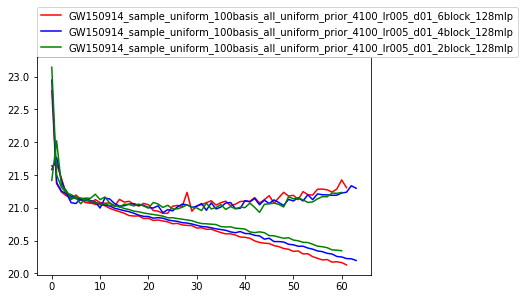

In [148]:
# !cat $addr'history.txt'
colors = ['r', 'b', 'g', 'y', 'k', 'c', 'm', 'r']
for addr, c in zip(model_list, colors):
    history = np.loadtxt('models/'+addr+'/history.txt')
    plt.plot(#history[:,0], 
             history[:,1],label=addr, c=c)
    plt.plot(#history[:,0], 
             history[:,2],c=c)

plt.legend(loc=[0,1]);

In [149]:
# js_GW170729_history = pd.read_csv('models/'+addr+'/js_GW150914_history.txt', sep='\t')
# [plt.plot(js_GW170729_history.iloc[:,i], label=js_GW170729_history.columns[i]) for i in range(15)]
# plt.legend();

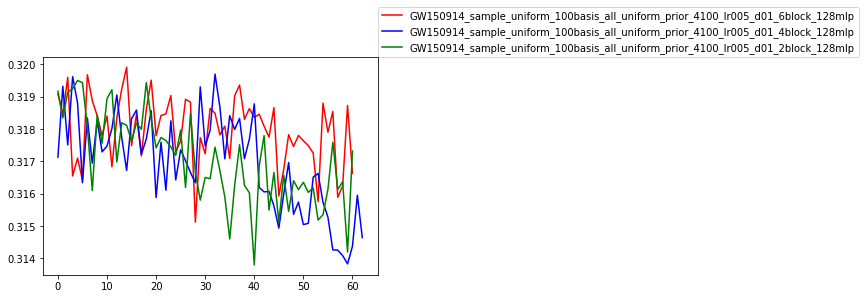

In [150]:
colors = ['r', 'b', 'g', 'y', 'k', 'c', 'm']
for addr, c in zip(model_list, colors):
    js_history = pd.read_csv('models/'+addr+'/js_GW150914_history.txt', sep='\t',)
    plt.plot(js_history.mean(1), label=addr, c=c)
plt.legend(loc=[1,1]);